In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, Input
from tensorflow.keras.layers import Embedding, LSTM, add, Reshape, concatenate
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from textwrap import wrap

# Data Preprocessing

## Define notebook-level constants

In [ ]:
IMAGE_PATH = './data/pictures_captions/Images/'
CAPTIONS_PATH = './data/pictures_captions/captions.txt'
START_SEQ = 'startseq'
END_SEQ = 'endseq'
IMG_SIZE = 224
SAVED_MODEL_FILE_NAME = 'model.h5'

## Read and sample dataset

In [ ]:
data = pd.read_csv(CAPTIONS_PATH)
data.sample(10)

image  \
13212  2685752892_9d5cd7f274.jpg   
38564   542405691_0594b1ce72.jpg   
4403   2058091220_2087270068.jpg   
19613  3077166963_fe172c709d.jpg   
7093   2280354512_c0d035d53f.jpg   
6480    224369028_b1ac40d1fa.jpg   
36742   456299217_b2802efbc2.jpg   
36823   460935487_75b2da7854.jpg   
14702  2787276494_82703f570a.jpg   
11783  2591455200_2319651f2f.jpg   

                                                 caption  
13212  a man wearing a blue shirt and hat jumping on ...  
38564  A little boy is kicking a blue ball on the car...  
4403        A person is hang gliding over a sandy area .  
19613  A young woman stands on a tree branch over a r...  
7093   A dog is being hit by a small wave in the ocean .  
6480   A little blonde girl is standing in front of a...  
36742  A woman sits on a wall next to a large conical...  
36823              A dog turning to look at the camera .  
14702  A person jumps off of a ledge into a body of w...  
11783                             Small girl in tunnel .

## Define utility functions to display images with captions

In [ ]:
def read_image(path: str, img_size: int = IMG_SIZE) -> np.array:
    if img_size is None:
        img = load_img(path, color_mode='rgb')
    else:
        img = load_img(path, color_mode='rgb',
                       target_size=(img_size, img_size))
    return img_to_array(img) / 255.0


def display_images(data: pd.DataFrame) -> None:
    data = data.reset_index(drop=True)
    plt.figure(figsize=(20, 14))

    for i in range(15):
        plt.subplot(3, 5, i + 1)
        image = read_image(f"{IMAGE_PATH}{data.image[i]}", None)
        plt.imshow(image)

        caption = data.caption[i]
        caption = caption.replace(START_SEQ, '').replace(END_SEQ, '')
        caption = "\n".join(wrap(caption, 20))

        plt.title(caption)
        plt.axis("off")

## Sample dataset (images \w captions)

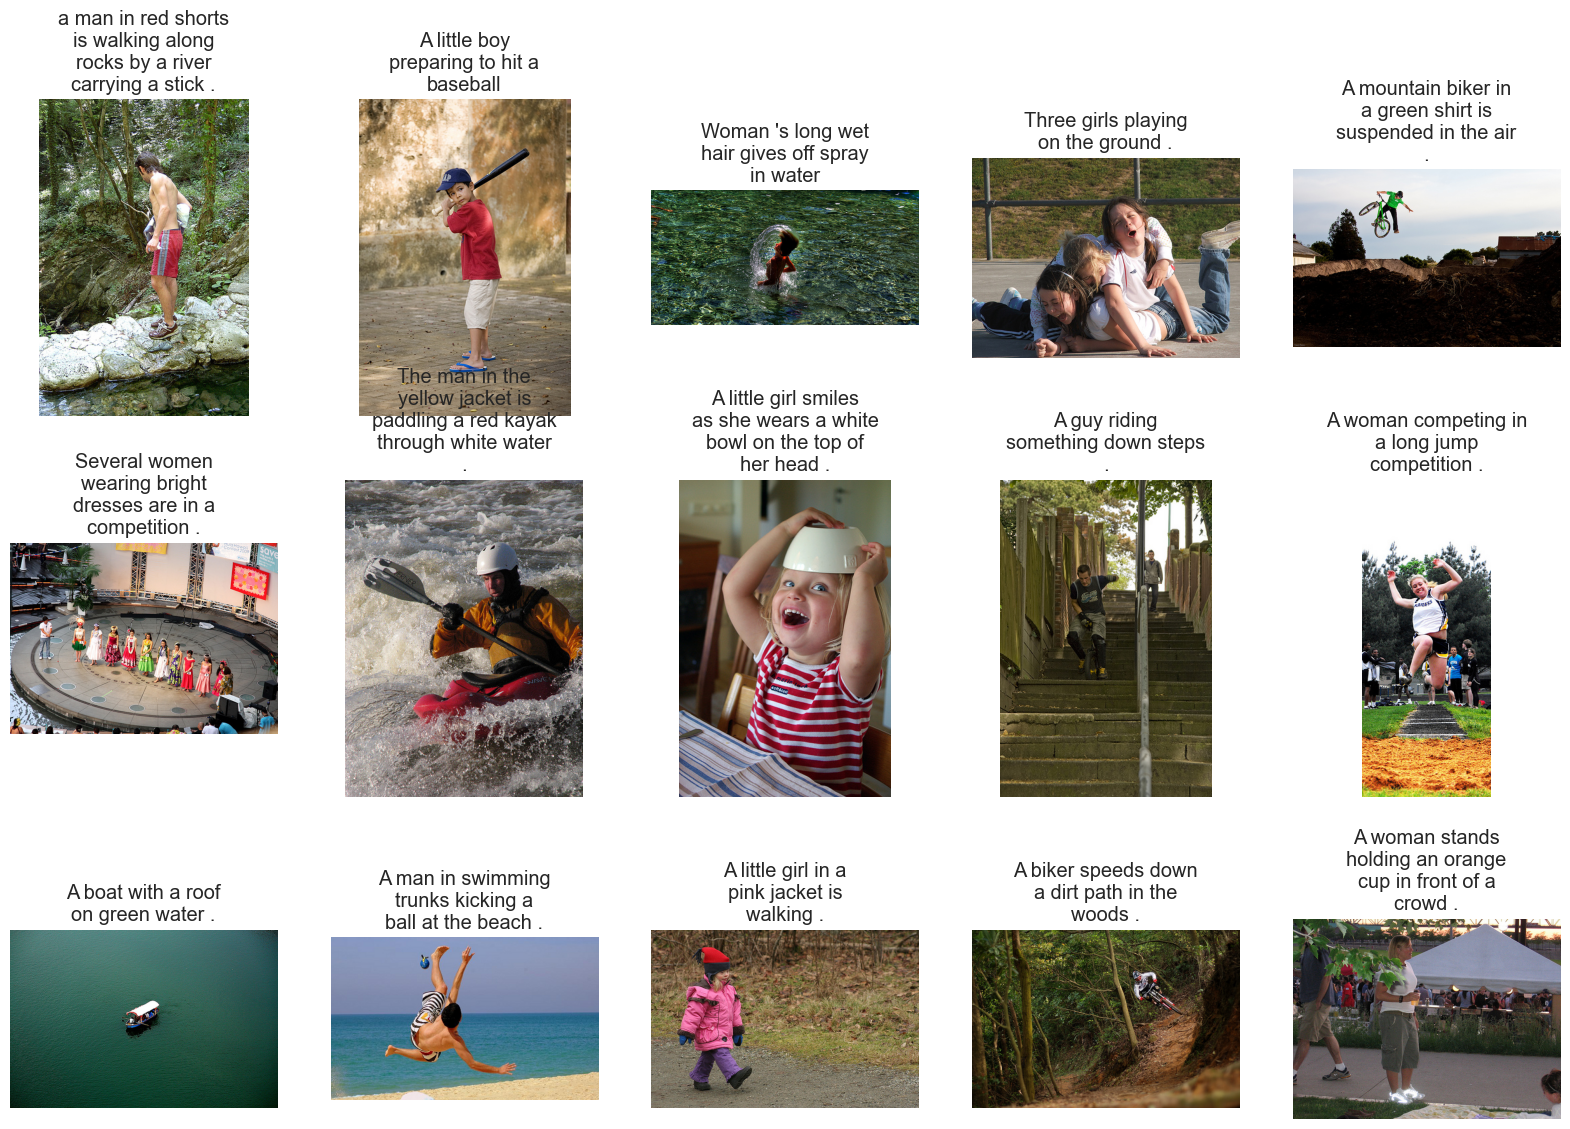

In [4]:
display_images(data.sample(15))

## Preprocess text data

In [ ]:
def preprocess_text(data: pd.Series) -> pd.Series:
    return data \
        .apply(lambda s: s.lower()) \
        .apply(lambda s: s.replace("[^A-Za-z]", "")) \
        .apply(lambda s: s.replace("\s+", " ")) \
        .apply(lambda s: " ".join([word for word in s.split() if len(word) > 1])) \
        .apply(lambda s: s.strip('\n\r \t')) \
        .apply(lambda s: s if s.startswith(START_SEQ) else START_SEQ + ' ' + s) \
        .apply(lambda s: s if s.endswith(END_SEQ) else s + ' ' + END_SEQ)

In [ ]:
data['caption'] = preprocess_text(data['caption'])
display(data['caption'].sample(10))

34646    startseq guy on bike jumps high into the air w...
10387       startseq motorcycle rider doing wheelie endseq
9669     startseq little girl slides down in the pool e...
39573    startseq two little girls on stone path holdin...
24108    startseq man wearing an orange u. miami t-shir...
17387    startseq man sitting on motorcycle with sunset...
26196    startseq an off-white dog has his mouth open a...
29236         startseq two men are fishing in river endseq
802           startseq dog jumps into backyard pool endseq
6659                startseq grey dove in bare tree endseq
Name: caption, dtype: object

## Tokenize text data

Use one-hot encoding and tf.keras.Tokenizer

In [ ]:
tokenizer = Tokenizer()

captions = data['caption'].tolist()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

# tokenizer.texts_to_sequences([captions[1]])[0]

## Split data for test and train subsets

In [154]:
images = data['image'].unique()

train_images, validation_images = train_test_split(images, test_size=0.15)

train_data = data[data['image'].isin(train_images)]
validation_data = data[data['image'].isin(validation_images)]

train_data.reset_index(inplace=True, drop=True)
validation_data.reset_index(inplace=True, drop=True)

# Extract image features

Use pre-trained CNN to extract images features

In [ ]:
model = DenseNet201()
features_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(IMAGE_PATH, image),
                   target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    feature = features_extractor.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 8091/8091 [20:57<00:00,  6.43it/s]


## Define DataGenerator

In [ ]:
class DataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.df.iloc[index
                             * self.batch_size:(index + 1)
                             * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]
                                 == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq],
                                           maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq],
                                             num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

## Define Caption Model

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

## Display model summary

In [ ]:
caption_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 256)          491776      ['input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 256)       0           ['dense_3[0][0]']                
                                                                                            

In [ ]:
train_generator = DataGenerator(df=train_data,
                                X_col='image',
                                y_col='caption',
                                batch_size=128,
                                directory=IMAGE_PATH,
                                tokenizer=tokenizer,
                                vocab_size=vocab_size,
                                max_length=max_length,
                                features=features)

validation_generator = DataGenerator(df=validation_data,
                                     X_col='image',
                                     y_col='caption',
                                     batch_size=128,
                                     directory=IMAGE_PATH,
                                     tokenizer=tokenizer,
                                     vocab_size=vocab_size,
                                     max_length=max_length,
                                           features=features)

## Define utility helpers for the training

In [ ]:
checkpoint = ModelCheckpoint(SAVED_MODEL_FILE_NAME,
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=3,
                               verbose=1,
                               restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=2,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=1e-8)

## Train Caption Model

In [ ]:
history = caption_model.fit(train_generator,
                            epochs=30,
                            validation_data=validation_generator,
                            callbacks=[checkpoint,
                                       early_stopping,
                                       learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 5.1653
Epoch 1: val_loss improved from inf to 4.26784, saving model to model.h5
537/537 [==============================] - 954s 2s/step - loss: 5.1653 - val_loss: 4.2678 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.2045
Epoch 2: val_loss improved from 4.26784 to 3.92094, saving model to model.h5
537/537 [==============================] - 190s 353ms/step - loss: 4.2045 - val_loss: 3.9209 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.9498
Epoch 3: val_loss improved from 3.92094 to 3.79587, saving model to model.h5
537/537 [==============================] - 189s 353ms/step - loss: 3.9498 - val_loss: 3.7959 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.7869
Epoch 4: val_loss improved from 3.79587 to 3.72960, saving model to model.h5
537/537 [==============================] - 193s 359ms/step - loss: 3.7869

## Display Training Results

* No overfitting due to EarlyStopping helper
* Effectiveness reduced after 7th epoch

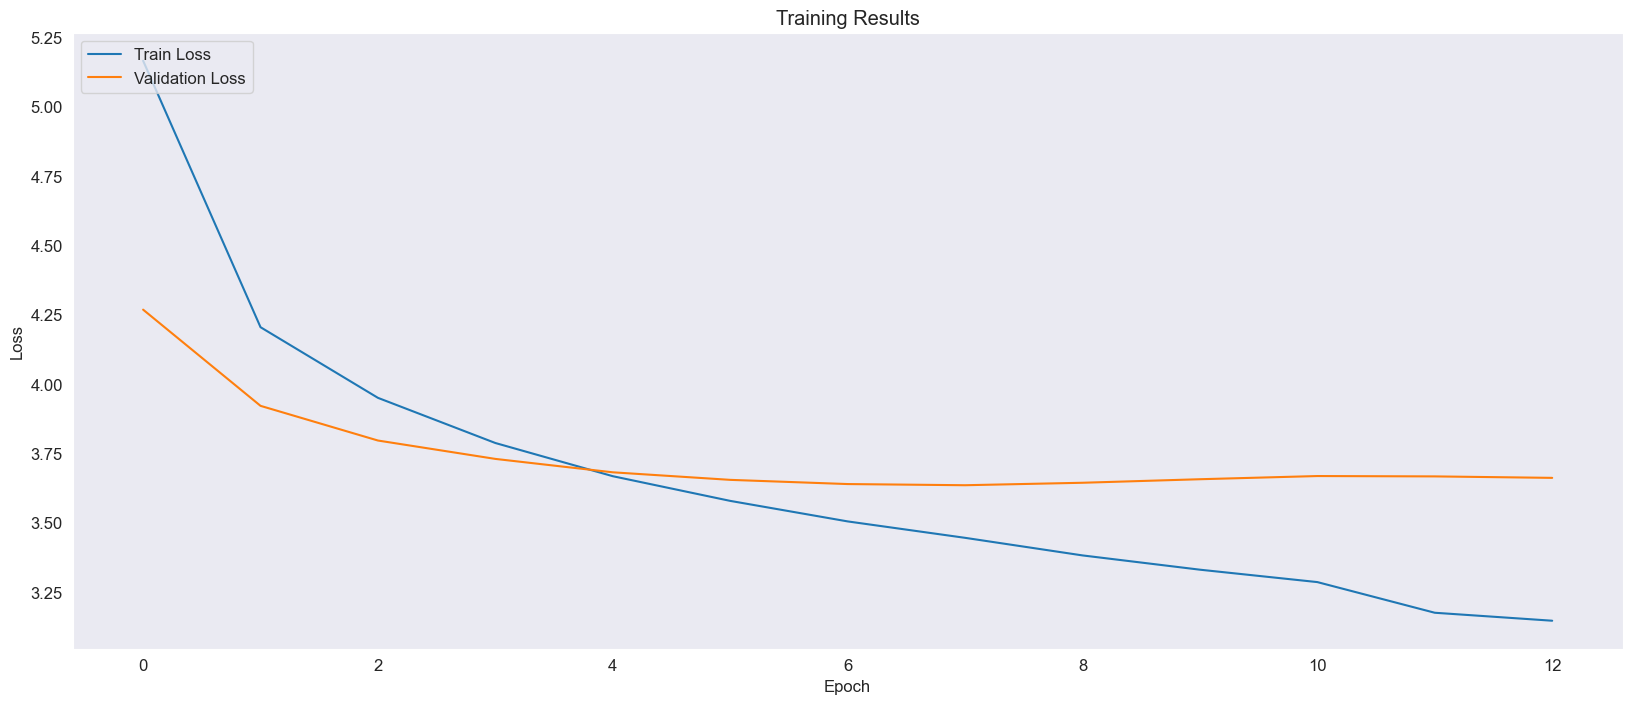

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Results')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper left')
plt.show()

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

## Check the model results

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = START_SEQ
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature, sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text += " " + word

        if word == END_SEQ:
            break

    return in_text

In [ ]:
def demo_prediction():
    samples = validation_data.sample(15)
    samples.reset_index(drop=True, inplace=True)

    for index, record in samples.iterrows():
        img = load_img(os.path.join(IMAGE_PATH, record['image']),
                       target_size=(224, 224))
        img = img_to_array(img)
        img = img / 255.0

        caption = predict_caption(caption_model,
                                  record['image'],
                                  tokenizer,
                                  max_length,
                                  features)
        samples.loc[index, 'caption'] = caption

    return samples

In [ ]:
samples = demo_prediction()

1/1 [==============================] - 0s 21ms/step


# Model Results

* General result is satisfying
* Model has obvious problems with clothes and colors

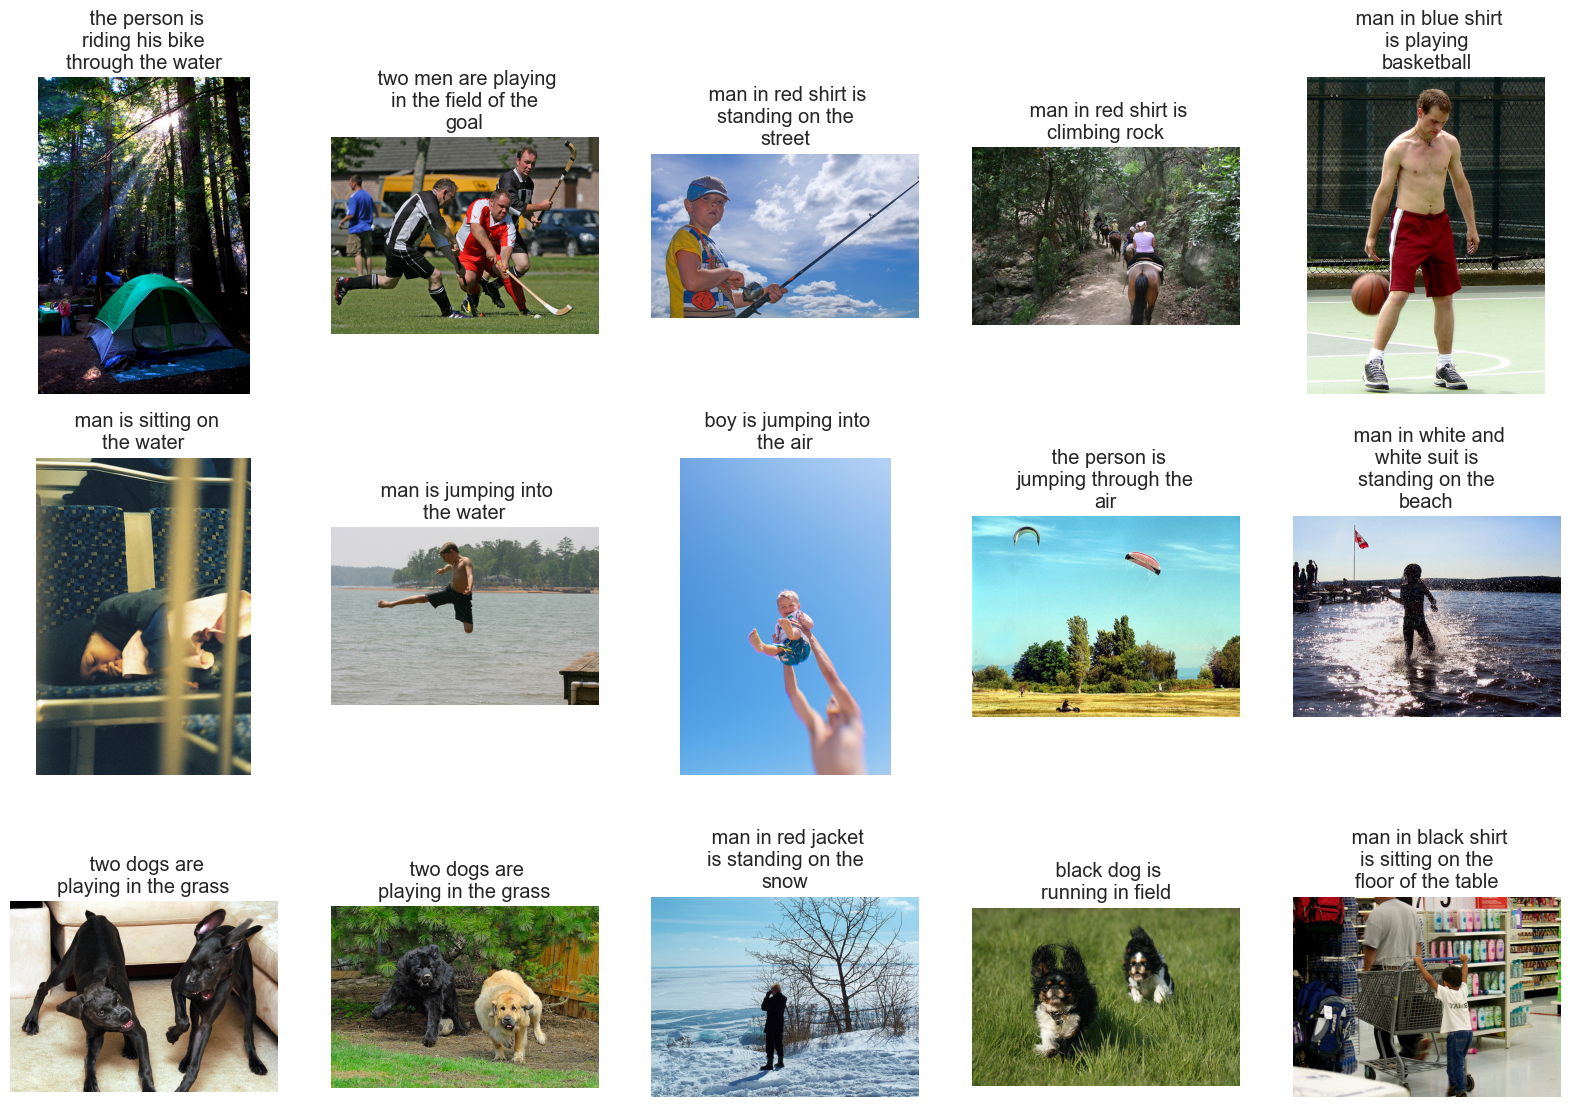

In [25]:
display_images(samples)

1/1 [==============================] - 0s 20ms/step


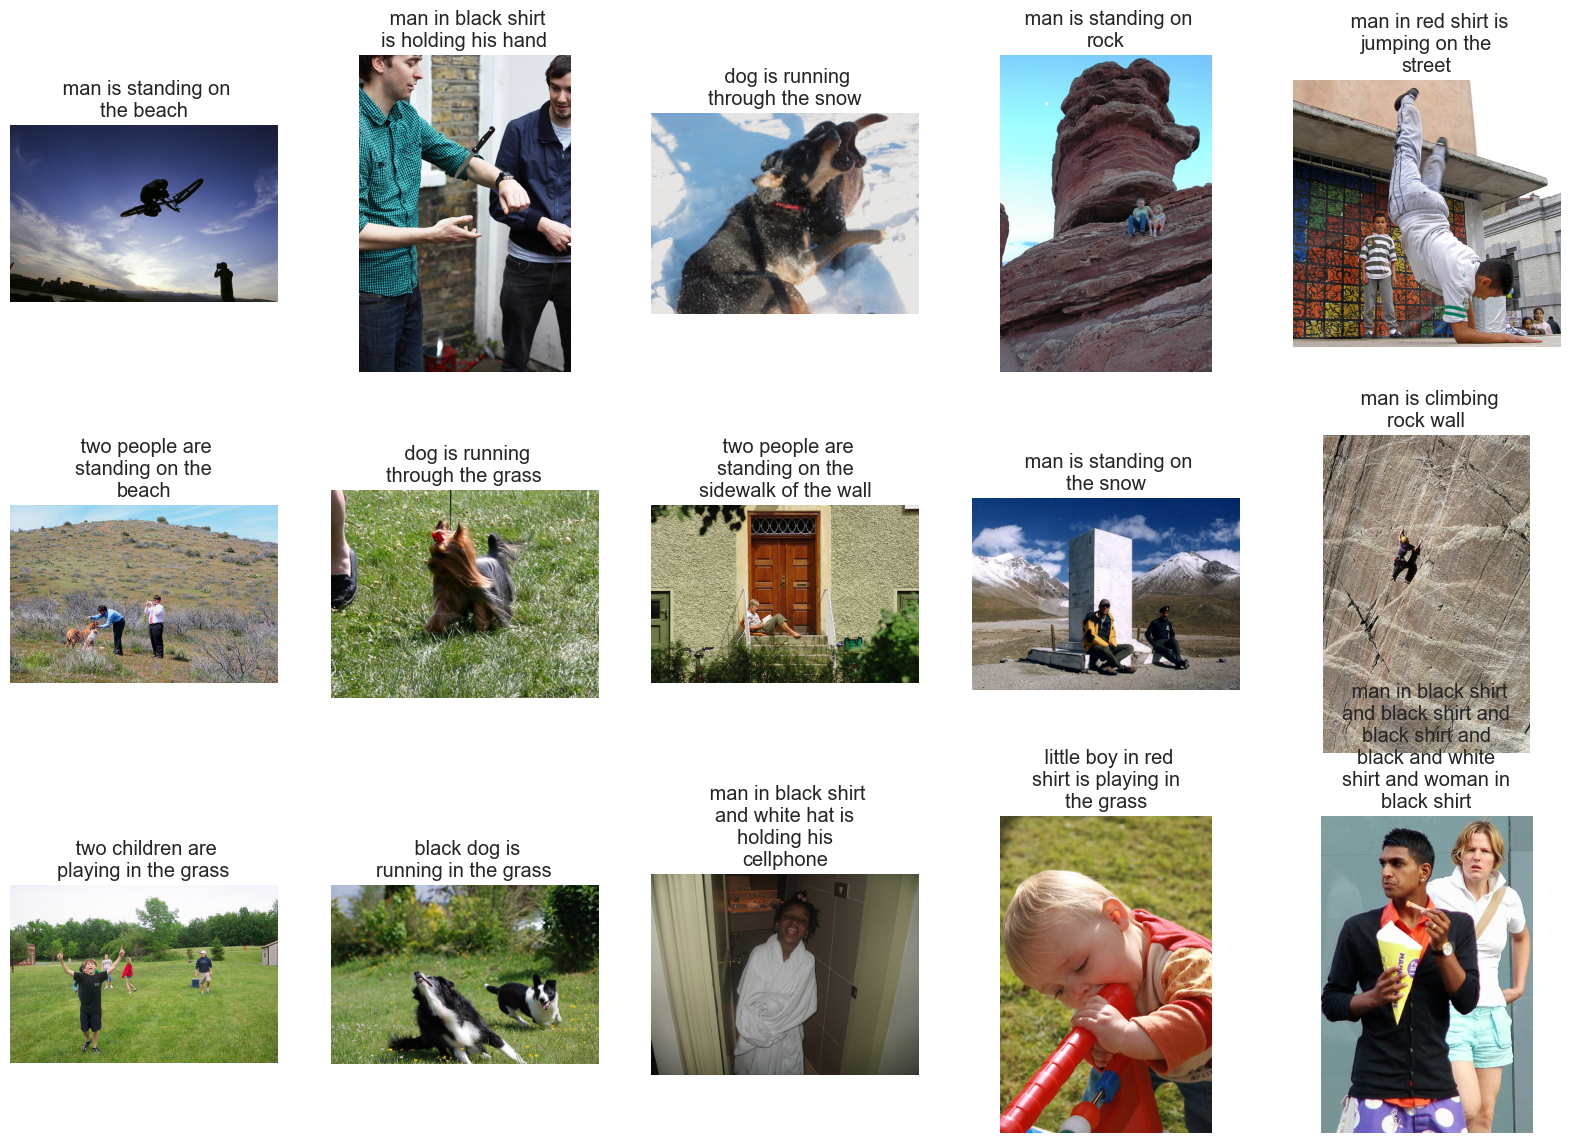

In [ ]:
samples = demo_prediction()
display_images(samples)

In [ ]:
# groups = captions.groupby('image').groups
# ROWS = 4
# COLS = 4
# LIMIT = ROWS * COLS
# i = 0
# fig = plt.figure(figsize=(20,20))
# description = ''

# for img_name in captions['image'].unique():
#     img = mpl.image.imread('./data/pictures_captions/Images/' + img_name)

#     ax = fig.add_subplot(ROWS, COLS, i + 1)
#     ax.set_title('Image ' + str(i + 1))
#     ax.set_xticks([])
#     ax.set_yticks([])
#     description += '\n\nImage' + str(i + 1) + '\n' + '\n'.join(captions['caption'][groups[img_name]].tolist())

#     plt.imshow(img)

#     i += 1
#     if i == LIMIT:
#         break

# fig.text(0.95, 0.05, description)
# plt.show()